# `GemPy` $\Rightarrow$ `discretize` $\Rightarrow$ `emg3d`

A first test at creating a model with [GemPy](https://gempy.org), populating it with resistivities, move it into [discretize](http://discretize.simpeg.xyz), and calculate CSEM data with [emg3d](https://empymod.github.io). Having it in discretize allows us to plot it in VTK directly in the notebook using [PyVista](https://github.com/pyvista)

In [1]:
import panel
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm

import emg3d
import vista
import discretize
import gempy as gp

## Creating a geological model

We start by using the model given in [Chapter 1.1](https://nbviewer.jupyter.org/github/cgre-aachen/gempy/blob/master/notebooks/tutorials/ch1-1_Basics.ipynb) of the GemPy documentation.

**Note:** We load csv-files here, from the above example in Chapter 1.1. I changed the stratigraphic unit names, and moved the model 2 km down. We could initiate an empty instance instead, and then add points and orientations after that with, e.g., providing numpy arrays.

In [2]:
# Initiate a model
geo_model = gp.create_model('gempy-discretize-emg3d')

# Importing the data from CSV-files and setting extent and resolution
gp.init_data(
    geo_model,
    [0,2000., 0,2000., -2000, 40.],[50, 50, 51],   # This is a regular grid, mainly for plotting purposes
    path_o = "data/simple_fault_model_orientations.csv",
    path_i = "data/simple_fault_model_points.csv",
    default_values=True
)

gempy-discretize-emg3d  2019-05-09 21:47

We run the plot settings here. For an issue with `init_data`, that would create a big white empty space if we set `%matplotlib notebook` before.

TODO: Create an issue.

In [3]:
%matplotlib notebook
plt.style.use('ggplot')

## Initiate the stratigraphies and faults, and add resistivities to lithology

In [4]:
# Add an air-layer: Horizontal layer at z=0m
geo_model.add_surfaces('air')
geo_model.add_surface_points(0, 0, 0, 'air')
geo_model.add_surface_points(0, 0, 0, 'air')
geo_model.add_orientations(0, 0, 0, 'air', [0, 0, 1])

# Add a Series for the air layer; this series will not be cut by the fault
geo_model.add_series('Air_Series')
geo_model.modify_order_series(2, 'Air_Series')
gp.map_series_to_surfaces(geo_model, {'Air_Series': 'air'})

# Map the different series
gp.map_series_to_surfaces(
    geo_model,
    {
        "Fault_Series": 'fault', 
        "Air_Series": ('air'),
        "Strat_Series": ('seawater', 'overburden', 'target', 'underburden', 'basement')
    },
    remove_unused_series=True
)

surface        series  order_surfaces  isBasement    color vertices edges  id
6          air    Air_Series               1       False  #325916      NaN   NaN   1
4        fault  Fault_Series               1       False  #443988      NaN   NaN   2
0       target  Strat_Series               1       False  #015482      NaN   NaN   3
1  underburden  Strat_Series               2       False  #9f0052      NaN   NaN   4
2   overburden  Strat_Series               3       False  #ffbe00      NaN   NaN   5
3     seawater  Strat_Series               4       False  #728f02      NaN   NaN   6
5     basement  Strat_Series               5        True  #ff3f20      NaN   NaN   7

In [5]:
# Set which series the fault series is cutting
geo_model.set_is_fault('Fault_Series')
geo_model.faults.faults_relations_df

Fault colors changed. If you do not like this behavior, set change_color to False.


Air_Series  Fault_Series  Strat_Series
Air_Series         False         False         False
Fault_Series       False         False          True
Strat_Series       False         False         False

In [6]:
#gp.plot.plot_3D(geo_model);

## Model generation


In [7]:
gp.set_interpolation_data(
    geo_model,
    compile_theano=True,
    theano_optimizer='fast_compile',
    verbose=[]
)

Compiling theano function...
Compilation Done!


In [8]:
sol = gp.compute_model(geo_model, compute_mesh=True)

<IPython.core.display.Javascript object>


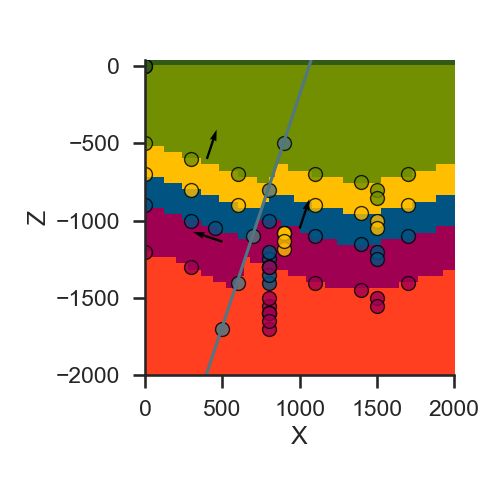

In [9]:
# Plot lithologies (colour-code corresponds to lithologies)
_ = gp.plot.plot_section(geo_model, cell_number=25, direction='y', show_data=True)

## Let's start with a discretize mesh for a CSEM survey

Source location and frequency

In [10]:
src = [1000, 1000, -500, 0, 0]  # x-directed e-source
freq = 1.0                      # Frequency

In [11]:
# Get calculation domain as a function of frequency (resp., skin depth)
hx_min, xdomain = emg3d.utils.get_domain(x0=src[0], freq=freq, limits=[0, 2000], min_width=[5, 100])
hz_min, zdomain = emg3d.utils.get_domain(freq=freq, limits=[-2000, 0], min_width=[5, 20], fact_pos=40)

# Create stretched grid
nx = 2**6
hx = emg3d.utils.get_stretched_h(hx_min, xdomain, nx, src[0])
hy = emg3d.utils.get_stretched_h(hx_min, xdomain, nx, src[1])
hz = emg3d.utils.get_stretched_h(hz_min, zdomain, nx*2, x0=src[2], x1=0)
grid = discretize.TensorMesh([hx, hy, hz], x0=(xdomain[0], xdomain[0], zdomain[0]))
grid

TensorMesh: 524,288 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     64       -378.34      2,378.34     43.07     43.07    1.00
   y     64       -378.34      2,378.34     43.07     43.07    1.00
   z    128     -2,000.00     11,334.05     20.00    531.76    1.05

## Put resistivities to stratigraphic units

We could define the resistivities before, but currently it is difficult for GemPy to interpolate for something like resistivities with a very wide range of values (several orders of magnitudes). So we can simply map it here to the `id` (GemPy does no interpolation).

In [12]:
# First, we have to get the id's for our mesh
sol = gp.compute_model_at(grid.gridCC, geo_model)

In [13]:
geo_model.surfaces

surface        series  order_surfaces  isBasement    color                                           vertices                                              edges  id
6          air    Air_Series               1       False  #325916  [[0.0, 0.0, -19.608001708984375], [0.0, 40.0, ...  [[2, 1, 0], [3, 1, 2], [3, 4, 1], [5, 4, 3], [...   1
4        fault  Fault_Series               1       False  #527682  [[400.0, 40.0, -1960.3840351104736], [400.0, 0...  [[2, 1, 0], [2, 0, 3], [3, 0, 4], [3, 4, 5], [...   2
3     seawater  Strat_Series               1       False  #728f02  [[1.0184168070554733, 40.0, -600.0], [40.0, 0....  [[2, 1, 0], [0, 1, 3], [0, 5, 4], [0, 4, 2], [...   3
2   overburden  Strat_Series               2       False  #ffbe00  [[33.07774066925049, 40.0, -840.0], [40.0, 0.0...  [[2, 1, 0], [0, 1, 3], [0, 5, 4], [0, 4, 2], [...   4
0       target  Strat_Series               3       False  #015482  [[0.0, 0.0, -1049.2594909667969], [0.0, 40.0, ...  [[2, 1, 0], [3, 1, 2], [3, 4, 1], [5, 4, 3], [...   5
1  underburden  Strat_Series               4       False  #9f0052  [[12.861340045928955, 40.0, -1360.0], [40.0, 0...  [[2, 1, 0], [0, 1, 3], [0, 5, 4], [0, 4, 2], [...   6
5     basement  Strat_Series               5        True  #ff3f20                                                NaN                                                NaN   7

In [14]:
# Now, we convert the id's to resistivities

res = sol[0][0, :grid.nC]

res[res == 1] = 2e14  # air
# id=2 is the fault
res[np.round(res) == 3] = 0.3  # sea water
res[np.round(res) == 4] = 1    # overburden
res[np.round(res) == 5] = 50   # target
res[np.round(res) == 6] = 1.5  # underburden
res[np.round(res) == 7] = 200  # basement

## Plot the input model

<IPython.core.display.Javascript object>


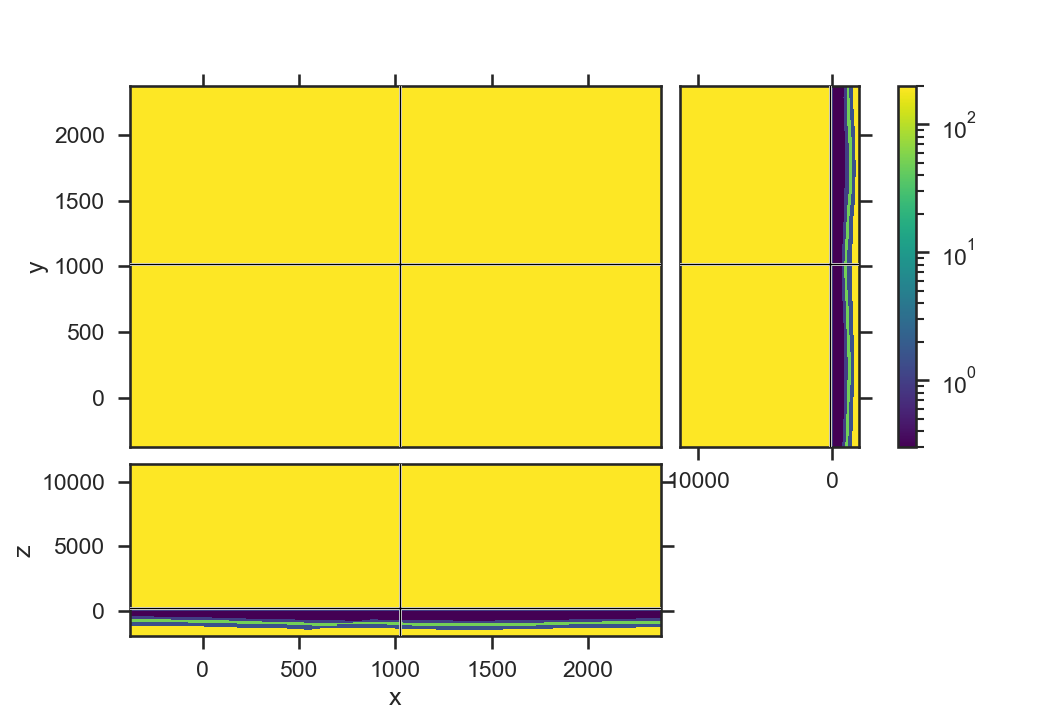

In [15]:
clim = [0.3, 200]
grid.plot_3d_slicer(res, clim=clim, pcolorOpts={'cmap': 'viridis', 'norm': LogNorm()})

In [16]:
dataset = grid.toVTK({'res': np.log10(res)})
dataset = dataset.clip_box(bounds=(0, 2000, 0, 2000, -2000, 0), invert=False)

# Create the rendering scene and add a grid axes
p = vista.Plotter(notebook=True)
p.show_grid(location='outer')

dparams = {'rng': np.log10(clim), 'cmap': 'viridis', 'show_edges': False}
# Add spatially referenced data to the scene
xyz = (1500, 500, -1500)
p.add_mesh(dataset.slice('x', xyz), name='x-slice', **dparams)
p.add_mesh(dataset.slice('y', xyz), name='y-slice', **dparams)
#p.add_mesh(dataset.slice('z', xyz), name='z-slice', **dparams)

# Add a layer as 3D
p.add_mesh(dataset.threshold([1.69, 1.7]),  name='vol', **dparams)

# Show the scene!
p.show(use_panel=True)

VTK(vtkXOpenGLRenderWindow, height=400, sizing_mode='stretch_width')

## Calculate the resistivities

In [17]:
# Create model
model = emg3d.utils.Model(grid, res, freq=freq)

# Source field
sfield = emg3d.utils.get_source_field(grid, src, freq, 0)

pfield = emg3d.solver.solver(grid, model, sfield, sslsolver=True, semicoarsening=True, linerelaxation=True, verb=3)


:: emg3d START :: 21:48:17 ::

   MG-cycle       : 'F'                 sslsolver : 'bicgstab'
   semicoarsening : True [1 2 3]        tol       : 1e-06
   linerelaxation : True [4 5 6]        maxit     : 50 (3)
   nu_{i,1,c,2}   : 0, 2, 1, 2          verb      : 3
   Original grid  :  64 x  64 x 128     => 524,288 cells
   Coarsest grid  :   2 x   2 x   2     => 8 cells
   Coarsest level :   5 ;   5 ;   6   

   [hh:mm:ss]     error          solver               MG          l s

       h_
      2h_ \                                        /
      4h_  \                            /\        / 
      8h_   \                  /\      /  \      /  
     16h_    \          /\    /  \    /    \    /   
     32h_     \    /\  /  \  /    \  /      \  /    
     64h_      \/\/  \/    \/      \/        \/      

   [21:48:28] 9.990e-09 after                       1 F-cycles;   4 1
   [21:48:36] 6.796e-10 after                       2 F-cycles;   5 2
   [21:48:46] 1.849e-10 after                

<IPython.core.display.Javascript object>


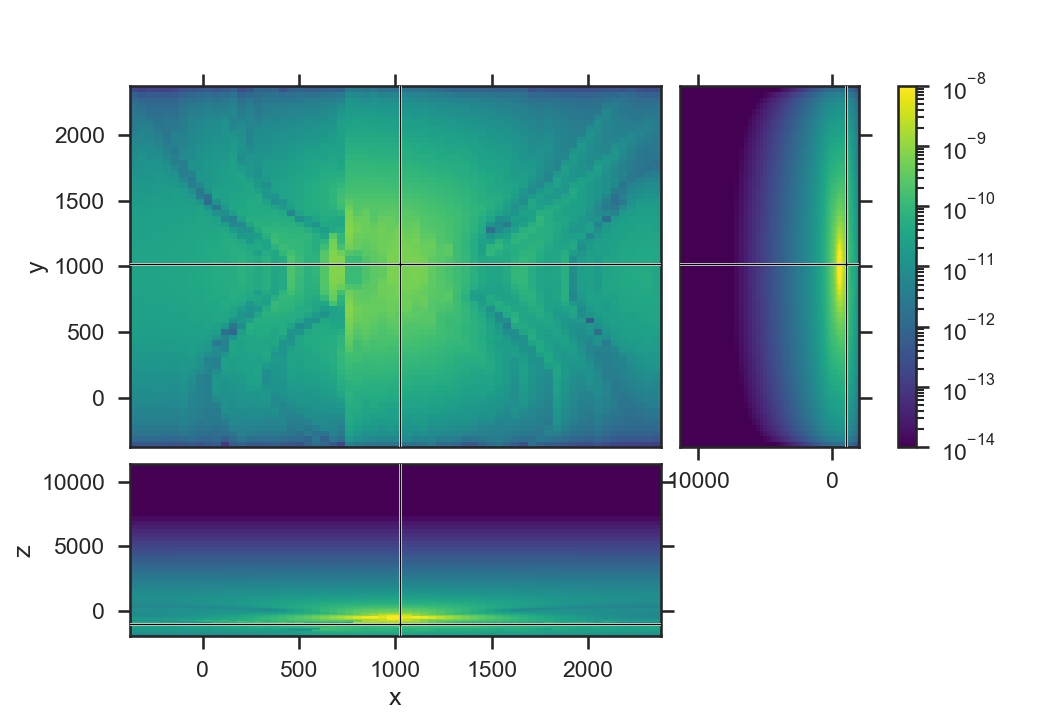

In [19]:
grid.plot_3d_slicer(pfield, zslice=-1000, view='abs', vType='Ex', clim=[1e-14, 1e-8],
                    pcolorOpts={'cmap': 'viridis', 'norm': LogNorm()})

In [20]:
emg3d.Versions([vista, panel, discretize])

------------------------------------------------------
  Thu May 09 21:49:42 2019 CEST

          Linux : OS
              4 : CPU(s)
         1.16.3 : numpy
          1.2.1 : scipy
         0.43.1 : numba
          0.5.0 : emg3d
          7.5.0 : IPython
          3.0.3 : matplotlib
         0.19.0 : vista
          0.5.1 : panel
          0.4.2 : discretize

  3.7.3 (default, Mar 27 2019, 22:11:17)  [GCC
  7.3.0]

  Intel(R) Math Kernel Library Version 2019.0.3
  Product Build 20190125 for Intel(R) 64
  architecture applications
------------------------------------------------------